In [1]:
"""
------------------------
Last Updated: 22/03/2022
------------------------

The purpose of this notebook is to look at how to efficiently translate parts of a smiles 
string into the accurate representative MARTINI beads. We will need to explore the functionalities of 
RDKit properly in this notebook to find how the segments of a smile can be translated.  Afterwards, 
we will test the code on multiple types of smiles strings to see whether they get the correct Martini translation.

-------------
Useful Links:
-------------

-> http://cgmartini.nl/index.php/martini-3-tutorials/parameterizing-a-new-small-molecule

-> https://chemrxiv.org/engage/chemrxiv/article-details/60f3ea062b910135237380eb 

-> https://www.nature.com/articles/s41592-021-01098-3

-> https://www.rdkit.org/docs/Cookbook.html

-> https://www.rdkit.org/docs/GettingStartedInPython.html

-> https://www.rdkit.org/docs/RDKit_Book.html

-> https://github.com/tbereau/auto_martini - Automated paramterization of smiles strings with MARTINI 

-> https://stackoverflow.com/questions/56581705/is-there-a-way-to-show-the-index-of-atoms-in-rdkit-chem-rdmolops-getadjacencymat - Adjancency matrices in rdkit 

-> https://docs.chemaxon.com/display/docs/r-group-decomposition-user-s-guide.md - Informationa about R-groups

-> https://iwatobipen.wordpress.com/2020/01/23/cut-molecule-to-ring-and-linker-with-rdkit-rdkit-chemoinformatics-memo/ 

-> https://iwatobipen.wordpress.com/

-> http://rdkit.org/docs/source/rdkit.Chem.Fragments.html - Fragment dividing - will be useful

-> https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html - SMARTS

-> http://rdkit.org/docs/source/rdkit.Chem.Fragments.html

-> https://rdkit.org/docs/source/rdkit.Chem.FragmentMatcher.html

-> https://andrewtarzia.github.io/posts/2022/01/molellipsize-post/

-> https://numba.pydata.org/ - speeding up the python code 

TODO: 
----

1. Find a flexible identifier which can find the indices of the smiles string, the coordinates of those strings,
   depending on the type of smiles pick out the true martini
   
2. Generate bond/angle parameters

3. Distinguish between aromatic/nonaromatic groups 

-------------------------------
Tips based on the Polyply paper: 
-------------------------------

1. Needs to be able to generate coordinates and parameters of the systems in question 

2. Needs to be an easy to use pipeline for generating input files and coordaintes based on the 
   system composition 
   
3. Needs to be able to combine input parameters and coordinates of polymeric systems with a variety
   of biomolecular structures 
    
4. TODO 

C => aliphatic carbon atom
c => aromatic carbon atom
a => aromatic atom
[#6] => carbon atom
[Ca] => calcium atom
[++] => atom with a +2 charge
[R] => atom in any ring
[D3] => atom with 3 explicit bonds (implicit H's don't count)
[X3] => atom with 3 total bonds (includes implicit H's)
[v3] => atom with bond orders totaling 3 (includes implicit H's)
C[C@H](F)O => match chirality (H-F-O anticlockwise viewed from C)
C[C@?H](F)O => matches if chirality is as specified or is not specified

"""

"\n------------------------\nLast Updated: 16/03/2022\n------------------------\n\nThe purpose of this notebook is to look at how to efficiently translate parts of a smiles \nstring into the accurate representative MARTINI beads. We will need to explore the functionalities of \nRDKit properly in this notebook to find how the segments of a smile can be translated.  Afterwards, \nwe will test the code on multiple types of smiles strings to see whether they get the correct Martini translation.\n\n-------------\nUseful Links:\n-------------\n\n-> http://cgmartini.nl/index.php/martini-3-tutorials/parameterizing-a-new-small-molecule\n\n-> https://chemrxiv.org/engage/chemrxiv/article-details/60f3ea062b910135237380eb \n\n-> https://www.nature.com/articles/s41592-021-01098-3\n\n-> https://www.rdkit.org/docs/Cookbook.html\n\n-> https://www.rdkit.org/docs/GettingStartedInPython.html\n\n-> https://www.rdkit.org/docs/RDKit_Book.html\n\n-> https://github.com/tbereau/auto_martini - Automated paramter

In [2]:
import sys

import numpy as np                                                                                                                                                                                         
import six 
import collections
import requests                                                                                                                                                                                            
from bs4 import BeautifulSoup                                                                                                                                                                              
from collections import Counter                                                                                                                                                                            
from scipy import ndimage


from rdkit import Chem
from rdkit import RDConfig  
from rdkit import DataStructs

from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import rdqueries
from rdkit.Chem import ChemicalFeatures                                                                                                                                                                    
from rdkit.Chem import rdchem                                                                                                                                                                              
from rdkit.Chem import rdmolops                                                                                                                                                                            
from rdkit.Chem import rdmolfiles                                                                                                                                                                          
from rdkit.Chem import rdMolDescriptors                                                                                                                                                                    
from rdkit.Chem import rdMolTransforms     
from rdkit import RDConfig                                                                                                                                                                                 
from rdkit.Chem.Fragments import fr_Ar_N
from rdkit.Chem import rdFMCS # rdkit - maximum common substructure
from rdkit.Chem.Draw import rdMolDraw2D


from itertools import chain                       
from collections import defaultdict                                                                                                                                                                        
from operator import itemgetter      

IPythonConsole.molSize = 250,250
import plotly.graph_objs as go

# MDAnalysis and Alignment libraries
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
import numpy as np 
import pandas as pd 


# scipy libaries                                                                                                                                                                                           
from scipy.sparse import csr_matrix                                                                                                                                                                        
from scipy.sparse.csgraph import floyd_warshall                                                                                                                                                            
from scipy.spatial import ConvexHull, convex_hull_plot_2d  
                                                                                                                                                                                                                                                                                                                                                                 
                                                                                                                                                                                                           
# Boilerplate libraries                                                                                                                                                                                    
import sys                                                                                                                                                                                                 
import re                                                                                                                                                                                                  
import math                                                                                                                                                                                                
import scipy                                                                                                                                                                                               
                                                                                                                                                                                                           
# scipy libaries                                                                                                                                                                                           
from scipy.sparse import csr_matrix                                                                                                                                                                        
from scipy.sparse.csgraph import floyd_warshall                                                                                                                                                            
from scipy.spatial import ConvexHull, convex_hull_plot_2d  

# Add Stero Annotations
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.addStereoAnnotation = True
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

In [3]:
"""
Example numba code 
https://numba.pydata.org/

"""

from numba import jit 
import random 

@jit(nopython = True)
def monte_carlo_pi(nsamples):
    """
    Description
    ------------
    """
    
    acc = 0 
    for i in range(nsamples):
        x = random.random()
        y = random.random()
        if (x ** 2 + y ** 2) < 1.0:
            acc += 1
    return 4.0 * acc / nsamples


In [2]:
import os

def include_weights(A,w):                                                                                                                                                                                  
    # Weights atoms by setting diagonal components                                                                                                                                                         
    A_weighted = np.copy(A)                                                                                                                                                                                
    for i,weight in enumerate(w):                                                                                                                                                                          
        A_weighted[i,i] = weight                                                                                                                                                                           
                                                                                                                                                                                                           
    return A_weighted 


def rank_nodes(A):                                                                                                                                                                                         
    # Ranks nodes by absolute eigenvector components of largest eigenvalue                                                                                                                                 
    vals,vecs = np.linalg.eig(A)                                                                                                                                                                           
    maxval = np.argmax(vals)                                                                                                                                                                               
    scores = np.absolute(vecs[:,maxval])                                                                                                                                                                   
    scores = scores/np.amin(scores)                                                                                                                                                                        
    ranked = np.argsort(scores)                                                                                                                                                                            
                                                                                                                                                                                                           
    ties = []                                                                                                                                                                                              
    sublist = []                                                                                                                                                                                           
                                                                                                                                                                                                           
    # Create ranked list with tied nodes at the same rank                                                                                                                                                  
    score_prev = scores[ranked[0]]                                                                                                                                                                         
    for i in ranked:                                                                                                                                                                                       
        score_i = scores[i]                                                                                                                                                                                
        if np.isclose(score_i,score_prev):                                                                                                                                                                 
            sublist.append(i)                                                                                                                                                                              
        else:                                                                                                                                                                                              
            ties.append(sublist)                                                                                                                                                                           
            sublist = [i]                                                                                                                                                                                  
        score_prev = score_i                                                                                                                                                                               
    ties.append(sublist)    
    
def get_hbonding(mol,beads):                                                                                                                                                                               
    #Extracts h-bonding behaviour for all beads in molecule                                                                                                                                                
    fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')                                                                                                                                        
    factory = ChemicalFeatures.BuildFeatureFactory(fdefName)                                                                                                                                               
    feats = factory.GetFeaturesForMol(mol)                                                                                                                                                                 
                                                                                                                                                                                                           
    h_donor = []                                                                                                                                                                                           
    h_acceptor = []                                                                                                                                                                                        
    for feat in feats:                                                                                                                                                                                     
        if feat.GetFamily() == "Donor":                                                                                                                                                                    
            for i in feat.GetAtomIds():                                                                                                                                                                    
                for b,bead in enumerate(beads):                                                                                                                                                            
                    if i in bead:                                                                                                                                                                          
                       if b not in h_donor:                                                                                                                                                                
                           h_donor.append(b)                                                                                                                                                               
                       break                                                                                                                                                                               
        if feat.GetFamily() == "Acceptor":                                                                                                                                                                 
            for i in feat.GetAtomIds():                                                                                                                                                                    
                for b,bead in enumerate(beads):                                                                                                                                                            
                    if i in bead:                                                                                                                                                                          
                       if b not in h_acceptor:                                                                                                                                                             
                           h_acceptor.append(b)                                                                                                                                                            
                       break                                                                                                                                                                               
                                                                                                                                                                                                           
    return h_donor,h_acceptor                 

def read_DG_data(DGfile):                                                                                                                                                                                  
    # Reads Delta G_OW for fragments into dictionary                                                                                                                                                       
    DG_data = {}                                                                                                                                                                                           
    with open(DGfile) as f:                                                                                                                                                                                
        for line in f:                                                                                                                                                                                     
            (key,val) = line.rstrip().split()                                                                                                                                                              
            DG_data[key] = float(val)                                                                                                                                                                      
                                                                                                                                                                                                           
    return DG_data          

def get_types(beads,mol,ring_beads):                                                                                                                                                                       
    #loops through beads and determines bead type                                                                                                                                                          
    path = os.path.dirname(os.path.realpath(__file__))                                                                                                                                                     
    DG_data = read_DG_data('/home/sang/Desktop/GIT/MDNPPackage/temp/cgparam/fragment_DGs.dat')                                                                                                
    bead_types = []                                                                                                                                                                                        
    charges = []                                                                                                                                                                                           
    all_smi = []
    # Need explanation 
    h_donor,h_acceptor = get_hbonding(mol,beads)                                                                                                                                                           
    for i,bead in enumerate(beads):                                                                                                                                                                        
        qbead = sum([mol.GetAtomWithIdx(int(j)).GetFormalCharge() for j in bead])                                                                                                                          
        charges.append(qbead)                                                                                                                                                                              
        bead_smi,ring_size, frag_size = get_smi(bead,mol)                                                                                                                                                  
        all_smi.append(bead_smi)                                                                                                                                                                           
        bead_types.append(param_bead(bead,bead_smi,ring_size,frag_size,any(i in ring for ring in ring_beads),qbead,i in h_donor,i in h_acceptor,DG_data))     

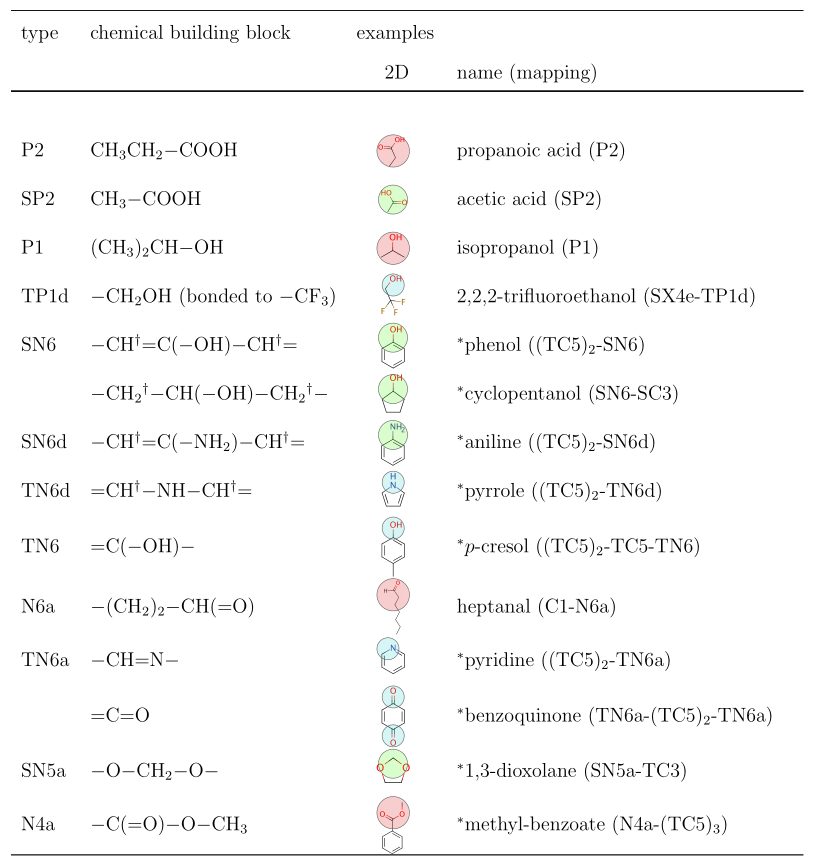

In [240]:
# https://docs.mdanalysis.org/1.1.1/documentation_pages/topology/ITPParser.html
import MDAnalysis as mda
u = mda.Universe('/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono/1MIMI_cog.itp', topology_format='ITP')

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/core/universe.py:147: UserWarning: No coordinate reader found for /home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono/1MIMI_cog.itp. Skipping this file.
  warnings.warn('No coordinate reader found for {}. Skipping '


In [3]:
u.bonds[0].length()




NameError: name 'u' is not defined

In [5]:
"""
All functions are on this cell  
"""

def Martini_smallmolecules():
    """
    Description 
    -----------
    
    
    """
    MartiniMoleculeDict = {}
    MartiniMoleculeDict['I_MIMI'] = 'Cn1ccnc1'
    MartiniMoleculeDict['II_MPYR'] = 'Cc1ccccn1'
    MartiniMoleculeDict['II_NIMX'] = 'Cc1c(c(ccc1)C)[N+](=O)[O-]'
    MartiniMoleculeDict['II_NITL'] = 'Cc1ccccc1[N+](=O)[O-]'
    MartiniMoleculeDict['II_T'] = 'c1cc(sc1)c2cccs2'
    MartiniMoleculeDict['III_HT'] = 'CCCCCCc1ccsc1'
    MartiniMoleculeDict['III_PT'] = 'CCCc1ccsc1'
    MartiniMoleculeDict['IV_MIMI'] = '[nH]1cc(nc1)C'
    MartiniMoleculeDict['IV_NIAN'] = 'COc1ccc(cc1)[N+](=O)[O-]'
    MartiniMoleculeDict['ACPH'] = 'CC(=O)c1ccccc1'
    MartiniMoleculeDict['ANIL'] = 'Nc1ccccc1'
    MartiniMoleculeDict['ANTH'] = 'c1ccc2cc3ccccc3cc2c1'
    MartiniMoleculeDict['BEAL'] = 'O=Cc1ccccc1'
    MartiniMoleculeDict['BENZ'] = 'c1ccccc1'
    MartiniMoleculeDict['BRA'] = 'COc1ccc(cc1)Br'
    MartiniMoleculeDict['BRBZ'] = 'c1ccc(cc1)Br'
    MartiniMoleculeDict['BZDOL'] = 'Oc1cc(ccc1)O'
    MartiniMoleculeDict['BZIM'] = 'c1ccc2c(c1)[nH]cn2'
    MartiniMoleculeDict['BZNI'] = 'N#Cc1ccccc1'
    
    
    return MartiniMoleculeDict 


def get_ring_atoms(mol):                                                                                                                                                                                   
    #get ring atoms and systems of joined rings                                                                                                                                                            
                                                                                                                                                                                                           
    rings = mol.GetRingInfo().AtomRings()                                                                                                                                                                  
    ring_systems = []                                                                                                                                                                                      
    for ring in rings:                                                                                                                                                                                     
        ring_atoms = set(ring)                                                                                                                                                                             
        new_systems = []                                                                                                                                                                                   
        for system in ring_systems:                                                                                                                                                                        
            shared = len(ring_atoms.intersection(system))                                                                                                                                                  
            if shared:                                                                                                                                                                                     
                ring_atoms = ring_atoms.union(system)                                                                                                                                                      
            else:                                                                                                                                                                                          
                new_systems.append(system)                                                                                                                                                                 
        new_systems.append(ring_atoms)                                                                                                                                                                     
        ring_systems = new_systems                                                                                                                                                                         
                                                                                                                                                                                                           
    return [ring for ring in ring_systems]              

def generate_structure_from_smiles(smiles):
    """
    """
    # Generate a 3D structure from smiles

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    status = AllChem.EmbedMolecule(mol)
    status = AllChem.UFFOptimizeMolecule(mol)

    conformer = mol.GetConformer()
    coordinates = conformer.GetPositions()
    coordinates = np.array(coordinates)

    atoms = get_atoms(mol)

    return atoms, coordinates 


def get_best_matching_fragment(mol):
    """
    Description 
    ------------
    
    """
    FragmentDict = {}
    # List the smarts strings that match the martini representations 
    
    thiophene = 'C1=CSC=C1'
    propanoic_acid = '[#6](-[#6]-[#6])(=[#8])-[#8]-[#1]'
    acetic_acid = ''
    
    #mols = [m,substructure] 
    #res=rdFMCS.FindMCS(mols)
    #res.smartsString
    
    
    FragmentDict['SC6'] = thiphene
    FragmentDict['P2'] = propanoic_acid 
    pass
    
    
def get_smarts_matches(mol):  
    """
    Description 
    -----------
    
    In the smiles molecular representation, find the most fitting 
    part and 
    
    
    """
    # Get matches to SMARTS strings
    """
    Reads in a dictionary of smiles that correspond to a 
    matching martini bead. 
    --
    Iterate through the smile and find the matches to the
    dictionary of smiles.
    --
    Then apend the indices, as well as the correpsonding mapped bead 
    we need to make 
    """
          
    smarts_strings = {                                                                                                                                                                                     
    'S([O-])(=O)(=O)O':'Qa',                                                                                                                                                                         
    'S([O-])(=O)(=O)[C;!$(*F)]':'Q0',
    'cc':'TC5',
    '[S](=O)(=O)(O[H])C':'Q0',
    'CC(=O)CO':'P2',
    'CS':'P',
    'cc': 'R'
    }                                                                                                                                                               
    matched_maps = []                                                                                                                                                                                      
    matched_beads = []                                                                                                                                                                                     
    for smarts in smarts_strings:                                                                                                                                                                          
        matches = mol.GetSubstructMatches(Chem.MolFromSmarts(smarts))                                                                                                                                      
        for match in matches:         
            matched_maps.append(match)                                                                                                                                                               
            matched_beads.append(smarts_strings[smarts])                                                                                                                                                   
                                                                                                                                                                                                           
    return matched_maps,matched_beads      





def group_rings(A,ring_atoms,matched_maps,moli):
    """
    Description
    -----------
    
    
    
    The edge_frag dictionary has a list of edge atoms
    
    We match the rings within the structure with these edge_frags dictionary. 
    
    """
    # Pre-processing step for ring structures    

    new_groups = []

    #List of possible edge fragments ordered by size, with mappings
    edge_frags = collections.OrderedDict()
    edge_frags["[R1][R1][R1][R1][R1][R1]"] =  [[0,1],[2,3],[4,5]]
    edge_frags["[R1][R1][R1][R1][R1]"] = [[0,1,2],[2,3]]
    edge_frags["[R1][R1][R1][R1]"] = [[0,1],[2,3]]
    edge_frags["[R1][R1][R1]"] =  [[0,1,2]]
    edge_frags["[R1][R1]"] = [[0,1]]
    edge_frags["[R2][R1][R2]"] = [[0,1,2]]

        #Map edges first
    for substruct in edge_frags:
        #matches = fragment.GetSubstructMatches(Chem.MolFromSmarts(substruct))
        matches = mol.GetSubstructMatches(Chem.MolFromSmarts(substruct)) 

        for match in matches:
            all_shared = False
            for system in ring_atoms:
                if all(m in system for m in match):
                    all_shared = True
                    break
            if not all_shared:
                continue
            if substruct == "[R2][R1][R2]":
                overlap = False
                for matchj in matches:            
                    #print(unmapped)
                    if match != matchj:
                        if list(set(match).intersection(matchj)):
                            overlap = True
                            break
                if overlap:
                    continue
            for bead in edge_frags[substruct]:
                test_bead = [match[x] for x in bead]
                if not any(any(y in ngroup for ngroup in new_groups) for y in test_bead):
                    new_groups.append(test_bead)

    #Get remaining unmapped atoms 
    unmapped = []
    for ring in ring_atoms:
        for a in ring:
            if not any(a in group for group in new_groups):
                unmapped.append(a)
    #Mapping of unmapped fragments
    if unmapped:
        #Split into continous fragments
        unm_smi = Chem.rdmolfiles.MolFragmentToSmiles(moli,unmapped)
        unm_smi = unm_smi.upper()
        unm_mol = Chem.MolFromSmiles(unm_smi)
        unmapped_frags = Chem.GetMolFrags(unm_mol)
        for frag in unmapped_frags:
            #Do mapping for each continuous fragment
            indices = [unmapped[k] for k in frag]
            frag_smi = Chem.rdmolfiles.MolFragmentToSmiles(moli,unmapped)
            frag_smi = frag_smi.upper()
            frag_mol = Chem.MolFromSmiles(frag_smi) 
            A_frag = np.asarray(Chem.GetAdjacencyMatrix(frag_mol))

            #Check if there are complete rings within unmapped fragments
            frag_ring_atoms = get_ring_atoms(frag_mol)
            if frag_ring_atoms:
                new_beads = group_rings(A_frag,frag_ring_atoms,matched_maps,frag_mol)[1]
            else:
                new_beads = []
            frag_ring_beads = new_beads[:]

            #Apply on iteration of graph-based mapping
            if sum([len(b) for b in frag_ring_beads]) < len(frag): 
                path_frag = floyd_warshall(csgraph=A_frag,directed=False)
                w_frag = [1.0 for atom in frag_mol.GetAtoms()] 
                A_fragw = include_weights(A_frag,w_frag)
                scores,ties = rank_nodes(A_fragw)
                comp = [[i] for i in range(frag_mol.GetNumAtoms())]            
         
                new_beads.extend(spectral_grouping(ties,A_frag,scores,frag_ring_beads,comp,path_frag,2,matched_maps)[0])
            for bead in new_beads:
                new_groups.append([indices[x] for x in bead])
              
    ring_beads = new_groups[:]
    # Add non-ring atoms
    new_groups += matched_maps
    for i in range(A.shape[0]):
        if not any(i in a for a in new_groups):
            new_groups.append([i])

    return ring_beads,new_groups,A 


In [5]:
class MolecularConverter:
    """
    From the smiles string provided by the user, this class 
    uses the most currrent mapping of the Martini beads avaliable, 
    and maps out the centers of geometries where the bead needs to be placed.
    ...
    
    Attributes
    ----------
    
    Methods:
    -------
    
    AssessSimilarity()
        TODO
    ComputeCoordinateLigands()
        TODO 
        
    """
    def __init__(self, smilesString):
        """                                                                                                                                                                                                              
        The constructor must detect whether the smiles string is valid or not                                                                                                                                            
        """        
        # Adding Martini Beads dictionary - at the moment, I am using                                                                                                                                                    
        # Martini 3 references
        
        """
        P2- Propanoic acid 
        SP2 - 
        """
        self._SmilesToMartiniDictionary = {}
        self._SmilesToMartiniDictionary["P2"] = "CC(=O)CO" # P2 Bead                                                                                                                                                           
        self._SmilesToMartiniDictionary["SP2"] = "CC(=O)O" # SP2 Bead                                                                                                                                                          
        self._SmilesToMartiniDictionary["P1"] =  "CC(C)O"                                                                                                                                                      
        # Depending on whether the nitrogen is on an pyrrole, pyridine, 
        # OH groups - depending on where it is bonded to the groups will be different 
        
        # Allocate smiles string 
        self._smilesString = smilesString
        
    def AssessSimilarity(self):
        """
        Parameters:
        -----------
        Assess the similarity of the molecule in question with the smiles 
        that match the Martini fragments. Using this, we can find 
        """
        AssessmentDictionary = {} 
        for entry in SmilesToMartiniDictionary.keys():
            MartiniExtract = Chem.MolFromSmarts(SmilesToMartiniDictionary[entry])
            AssessmentDictionary = print(molecule.HasSubstructMatch(MartiniExtract))
    
    def ComputeCoordinatesLigands(self):
        """                                                                                                                                                                                                              
        Get the generic basis of the xyz coorinates of the                                                                                                                                                               
        ligands                                                                                                                                                                                                          
        """
        # Creating the rdkit model 
        mol = Chem.MolFromSmiles(self._smilesString)
        mol = Chem.AddHs(mol)
        
        # Use MDAnalysis to create the structure 
        MolecularUniverse = mda.Universe.from_smiles(self._smilesString)
        Molecule = MolecularUniverse.select_atoms('all')
        MoleculeAtomPositions = Molecule.positions # Finds  
        PositionArray = []
        # Find the indices of the functional groups and find the center of mass 
        # of those indices 
        for i in MolecularUniverse.atoms:
            if i.index + 1  in [3,4,5]: # Find the index of the atoms which match the smile string 
                                # that match the MARTINI bead 
                PositionArray.append(list(i.position))
            
            
            
PositionArray= np.asarray(PositionArray)
averaged = np.average(PositionArray, axis=0)
averaged # Positions where the new MARTINI bead needs to be placed


#CM = ndimage.measurements.center_of_mass(PositionArray)

    def SubstructureSearch(self):
        """
        Loops through the MARTINI-3 SMILES extracts and tries to
        match whether the substructure exists within the molecular structure 
        
        Loops through the MARTINI-3 SMILES extracts and tries to 
        match whether the substruture exists 
        """
        pass

IndentationError: unexpected indent (<ipython-input-5-264bbc00b78b>, line 83)

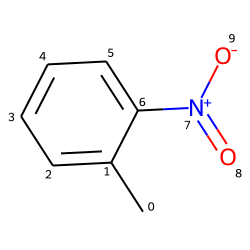

In [5]:


"""
Lets try making a martinized version of just one ligand
"""
u1 = mda.Universe.from_smiles("C1=C(C=CC=C1)CS[H]")
AromaticSulfurSmilesString = 'Cc1ccccc1[N+](=O)[O-]'
m_aromatic = Chem.MolFromSmiles(AromaticSulfurSmilesString)
#mol_with_atom_index(m_aromatic)
m_aromatic

In [202]:
def group_rings(A,ring_atoms,matched_maps,moli):
    # Pre-processing step for ring structures    

    new_groups = []

    #List of possible edge fragments ordered by size, with mappings
    edge_frags = collections.OrderedDict()
    edge_frags["[R1][R1][R1][R1][R1][R1]"] =  [[0,1],[2,3],[4,5]]
    edge_frags["[R1][R1][R1][R1][R1]"] = [[0,1,2],[2,3]]
    edge_frags["[R1][R1][R1][R1]"] = [[0,1],[2,3]]
    edge_frags["[R1][R1][R1]"] =  [[0,1,2]]
    edge_frags["[R1][R1]"] = [[0,1]]
    edge_frags["[R2][R1][R2]"] = [[0,1,2]]

        #Map edges first
    for substruct in edge_frags:
        #matches = fragment.GetSubstructMatches(Chem.MolFromSmarts(substruct))
        matches = moli.GetSubstructMatches(Chem.MolFromSmarts(substruct)) 

        for match in matches:
            all_shared = False
            for system in ring_atoms:
                if all(m in system for m in match):
                    all_shared = True
                    break
            if not all_shared:
                continue
            if substruct == "[R2][R1][R2]":
                overlap = False
                for matchj in matches:
                    if match != matchj:
                        if list(set(match).intersection(matchj)):
                            overlap = True
                            break
                if overlap:
                    continue
            for bead in edge_frags[substruct]:
                test_bead = [match[x] for x in bead]
                if not any(any(y in ngroup for ngroup in new_groups) for y in test_bead):
                    new_groups.append(test_bead)

    #Get remaining unmapped atoms 
    unmapped = []
    for ring in ring_atoms:
        for a in ring:
            if not any(a in group for group in new_groups):
                unmapped.append(a)
    #Mapping of unmapped fragments
    if unmapped:
        #Split into continous fragments
        unm_smi = Chem.rdmolfiles.MolFragmentToSmiles(moli,unmapped)
        unm_smi = unm_smi.upper()
        unm_mol = Chem.MolFromSmiles(unm_smi)
        unmapped_frags = Chem.GetMolFrags(unm_mol)
        for frag in unmapped_frags:
            #Do mapping for each continuous fragment
            indices = [unmapped[k] for k in frag]
            frag_smi = Chem.rdmolfiles.MolFragmentToSmiles(moli,unmapped)
            frag_smi = frag_smi.upper()
            frag_mol = Chem.MolFromSmiles(frag_smi) 
            A_frag = np.asarray(Chem.GetAdjacencyMatrix(frag_mol))

            #Check if there are complete rings within unmapped fragments
            frag_ring_atoms = get_ring_atoms(frag_mol)
            if frag_ring_atoms:
                new_beads = group_rings(A_frag,frag_ring_atoms,matched_maps,frag_mol)[1]
            else:
                new_beads = []
            frag_ring_beads = new_beads[:]

            #Apply on iteration of graph-based mapping
            if sum([len(b) for b in frag_ring_beads]) < len(frag): 
                path_frag = floyd_warshall(csgraph=A_frag,directed=False)
                w_frag = [1.0 for atom in frag_mol.GetAtoms()] 
                A_fragw = include_weights(A_frag,w_frag)
                scores,ties = rank_nodes(A_fragw)
                comp = [[i] for i in range(frag_mol.GetNumAtoms())]            
         
                new_beads.extend(spectral_grouping(ties,A_frag,scores,frag_ring_beads,comp,path_frag,2,matched_maps)[0])
            for bead in new_beads:
                new_groups.append([indices[x] for x in bead])
              
    ring_beads = new_groups[:]
    # Add non-ring atoms
    new_groups += matched_maps
    for i in range(A.shape[0]):
        if not any(i in a for a in new_groups):
            new_groups.append([i])

    return ring_beads,new_groups,A                 

def mapping(mol,ring_atoms,matched_maps,n_iter):
    #Initialise data structures
    #mol = Chem.MolFromSmiles(smiles)
    A_atom = np.asarray(Chem.GetAdjacencyMatrix(mol))
    path_matrix = floyd_warshall(csgraph=A_atom,directed=False)
    w_init = [atom.GetMass() for atom in mol.GetAtoms()]
    #w_init = [1.0 for atom in mol.GetAtoms()]

    # This part is the tricky part 
    ring_beads,comp,A_init = group_rings(A_atom,ring_atoms,matched_maps,mol)
    #w_init = get_weights(comp,w_init)

    # Do spectral mapping iterations
    results = []
    for itr in range(n_iter):
        results_dict,ring_beads,matched_maps = iteration(results,itr,A_init,w_init,ring_beads,path_matrix,matched_maps)
        results.append(results_dict)
 

    # Get final mapping
    results_dict_final = postprocessing(results,ring_atoms,n_iter,A_init,w_init,path_matrix,matched_maps)
    #sizes = get_sizes(results[best]['comp'],A_init)
    ring_beads = []
    for ring in ring_atoms:
        cgring = []
        for atom in ring:
            for i,bead in enumerate(results_dict_final['comp']):
                if (atom in bead) and (i not in cgring):
                    cgring.append(i)
        ring_beads.append(cgring)


        return results_dict_final['A'],results_dict_final['comp'],ring_beads#,sizes

def iteration(results,itr,A_init,w_init,ring_beads,path_matrix,matched_maps):                                                                                                                              
    """
    
    """
    
    results_dict = dict.fromkeys(['A','comp'])                                                                                                                                                             
                                                                                                                                                                                                           
    # Get properties of current mapping                                                                                                                                                                    
    if itr == 0:                                                                                                                                                                                           
        oldA = np.copy(A_init)                                                                                                                                                                             
        comp = [[i] for i in range(len(w_init))]                                                                                                                                                           
        w = w_init[:]                                                                                                                                                                                      
    else:                                                                                                                                                                                                  
        oldA = results[itr-1]['A']                                                                                                                                                                         
        comp = results[itr-1]['comp']                                                                                                                                                                      
        w = get_weights(comp,w_init,path_matrix)                                                                                                                                                           
                                                                                                                                                                                                           
    A_weighted = include_weights(oldA,w)                                                                                                                                                                   
                                                                                                                                                                                                           
    # Get new mapping scheme                                                                                                                                                                               
    scores,ties = rank_nodes(A_weighted)                                                                                                                                                                   
    groups,ring_beads,matched_maps = spectral_grouping(ties,oldA,scores,ring_beads,comp,path_matrix,3,matched_maps)                                                                                        
    results_dict['A'] = new_connectivity(groups,oldA)                                                                                                                                                      
                                                                                                                                                                                                           
    # Get atomistic composition of new mapping                                                                                                                                                             
    if itr == 0:                                                                                                                                                                                           
        results_dict['comp'] = groups[:]                                                                                                                                                                   
                                                                                                                                                                                                           
    else:                                                                                                                                                                                                  
        comp = []                                                                                                                                                                                          
        for gj in groups:                                                                                                                                                                                  
            bead_comp = list(itertools.chain.from_iterable([results[itr-1]['comp'][x] for x in gj]))                                                                                                       
            comp.append(bead_comp)                                                                                                                                                                         
                                                                                                                                                                                                           
        results_dict['comp'] = comp[:]                                                                                                                                                                     
    #pdrint(results_dict)                                                                                                                                                                                  
                                                                                                                                                                                                           
    return results_dict,ring_beads,matched_maps

def rank_nodes(A):                                                                                                                                                                                         
    # Ranks nodes by absolute eigenvector components of largest eigenvalue                                                                                                                                 
    vals,vecs = np.linalg.eig(A)  # vals - eigenvalues, v - eigenvectors                                                                                                                                                                       
    maxval = np.argmax(vals) # Get maximum value of the eigenvalues  
    """
    
    """
    scores = np.absolute(vecs[:,maxval])                                                                                                                                                                   
    scores = scores/np.amin(scores)                                                                                                                                                                        
    ranked = np.argsort(scores)                                                                                                                                                                            
                                                                                                                                                                                                           
    ties = []                                                                                                                                                                                              
    sublist = []                                                                                                                                                                                           
                                                                                                                                                                                                           
    # Create ranked list with tied nodes at the same rank                                                                                                                                                  
    score_prev = scores[ranked[0]]                                                                                                                                                                         
    for i in ranked:                                                                                                                                                                                       
        score_i = scores[i]                                                                                                                                                                                
        if np.isclose(score_i,score_prev):                                                                                                                                                                 
            sublist.append(i)                                                                                                                                                                              
        else:                                                                                                                                                                                              
            ties.append(sublist)                                                                                                                                                                           
            sublist = [i]                                                                                                                                                                                  
        score_prev = score_i                                                                                                                                                                               
    ties.append(sublist)                                                                                                                                                                                   
                                                                                                                                                                                                           
    return scores,ties               

In [237]:
matched_maps,matched_beads = get_smarts_matches(m_aromatic)
ring_atoms = get_ring_atoms(m_aromatic) # Get the ring indices 

A_atom = np.asarray(Chem.GetAdjacencyMatrix(m_aromatic))
path_matrix = floyd_warshall(csgraph=A_atom,directed=False)

w_init = [atom.GetMass() for atom in m_aromatic.GetAtoms()] 

#print(matched_maps, matched_beads, ring_atoms, A_atom, path_matrix, w_init)
ring_beads,comp,A_init = group_rings(A_atom,ring_atoms,matched_maps,m_aromatic) 
A_cg,beads,ring_beads = mapping(m_aromatic,ring_atoms,matched_maps,1)


#new_groups = []

#List of possible edge fragments ordered by size, with mappings
#edge_frags = collections.OrderedDict()
#edge_frags["[R1][R1][R1][R1][R1][R1]"] =  [[0,1],[2,3],[4,5]]
#edge_frags["[R1][R1][R1][R1][R1]"] = [[0,1,2],[2,3]]
#edge_frags["[R1][R1][R1][R1]"] = [[0,1],[2,3]]
#edge_frags["[R1][R1][R1]"] =  [[0,1,2]]
#edge_frags["[R1][R1]"] = [[0,1]]
#edge_frags["[R2][R1][R2]"] = [[0,1,2]]

#Map edges first
#for substruct in edge_frags:
#    #matches = fragment.GetSubstructMatches(Chem.MolFromSmarts(substruct))
#    matches = mol.GetSubstructMatches(Chem.MolFromSmarts(substruct)) 
#    print(matches)

matched_maps

TypeError: cannot unpack non-iterable NoneType object

In [236]:
results_dict = dict.fromkeys(['A','comp'])

if itr == 0:                                                                                                                                                                                           
    oldA = np.copy(A_init)                                                                                                                                                                             
    comp = [[i] for i in range(len(w_init))]                                                                                                                                                           
    w = w_init[:]        
else:                                                                                                                                                                                                  
    oldA = results[itr-1]['A']                                                                                                                                                                         
    comp = results[itr-1]['comp']                                                                                                                                                                      
    w = get_weights(comp,w_init,path_matrix)     

    
A_weighted = include_weights(oldA,w)
A_weighted
#for itr in range(3):
#    print(itr)
#    results_dict,ring_beads,matched_maps = iteration(results,itr,A_init,w_init,ring_beads,path_matrix,matched_maps)

array([[12,  1,  0,  0,  0,  1,  0,  0],
       [ 1, 12,  1,  0,  0,  0,  1,  0],
       [ 0,  1, 12,  1,  0,  0,  0,  0],
       [ 0,  0,  1, 12,  1,  0,  0,  0],
       [ 0,  0,  0,  1, 12,  1,  0,  0],
       [ 1,  0,  0,  0,  1, 12,  0,  0],
       [ 0,  1,  0,  0,  0,  0, 12,  1],
       [ 0,  0,  0,  0,  0,  0,  1, 32]], dtype=int32)

In [238]:
A_weighted



array([[12,  1,  0,  0,  0,  1,  0,  0],
       [ 1, 12,  1,  0,  0,  0,  1,  0],
       [ 0,  1, 12,  1,  0,  0,  0,  0],
       [ 0,  0,  1, 12,  1,  0,  0,  0],
       [ 0,  0,  0,  1, 12,  1,  0,  0],
       [ 1,  0,  0,  0,  1, 12,  0,  0],
       [ 0,  1,  0,  0,  0,  0, 12,  1],
       [ 0,  0,  0,  0,  0,  0,  1, 32]], dtype=int32)

In [176]:
def get_ring_atoms(mol):                                                                                                                                                                                   
    #get ring atoms and systems of joined rings                                                                                                                                                            
                                                                                                                                                                                                           
    rings = mol.GetRingInfo().AtomRings() # Returns list of indices of the rings atoms within the molecule                                                                                                                                                                  
    ring_systems = []                                                                                                                                                                                      
    for ring in rings:                                                                                                                                                                                     
        ring_atoms = set(ring)                                                                                                                                                                             
        new_systems = []                                                                                                                                                                                   
        for system in ring_systems:                                                                                                                                                                        
            shared = len(ring_atoms.intersection(system))                                                                                                                                                  
            if shared:                                                                                                                                                                                     
                ring_atoms = ring_atoms.union(system)                                                                                                                                                      
            else:                                                                                                                                                                                          
                new_systems.append(system)                                                                                                                                                                 
        new_systems.append(ring_atoms)                                                                                                                                                                     
        ring_systems = new_systems        
    
    return [list(ring) for ring in ring_systems] 
# Going through with example
                                                                                                                                                                                                           
rings = m_aromatic.GetRingInfo().AtomRings()
ring_systems = []
for ring in rings:
    ring_atoms = set(ring)
    new_systems = [] 
    for system in ring_systems:
        shared = len(ring_atoms.intersection(system))
        print(shared)
        if shared: # If we have anything assigned to shared.. 
            ring_atoms = ring_atoms.union(system)
        else:
            new_systems.append(system)
    new_systems.append(ring_atoms)
    ring_systems = new_systems
    print([ring for ring in ring_systems])
    

[{0, 1, 2, 3, 4, 5}]


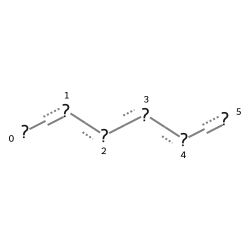

In [146]:
Chem.MolFromSmarts("[R1][R1][R1][R1][R1][R1]")

In [ ]:
# List of avaliable smiles files avaliable in the Martini 3 small molecules 

"""
1MIMI.smiles  4MIMI.smiles  BRA.smiles    BZTF.smiles   CLTL.smiles   DBRBZ.smiles  ENAPH.smiles  MBZOA.smiles  NAPH.smiles   PBEN.smiles   PYAZ.smiles  TCLBZ.smiles  THP.smiles
2MPYR.smiles  4NIAN.smiles  BRBZ.smiles   BZTH.smiles   CNAP.smiles   DCLBZ.smiles  FURA.smiles   MCYPE.smiles  NAPY.smiles   PBZOA.smiles  PYLI.smiles  TDMBI.smiles  THPY.smiles
2NIMX.smiles  ACPH.smiles   BZDOL.smiles  CAFF.smiles   CPR.smiles    DIOX.smiles   IMID.smiles   MESI.smiles   NBAPH.smiles  PCRE.smiles   PYMI.smiles  TECE.smiles   THT.smiles
2NITL.smiles  ANIL.smiles   BZIM.smiles   CHEXE.smiles  CUME.smiles   DMAN.smiles   INDA.smiles   MINDA.smiles  NDMBI.smiles  PCYM.smiles   PYRI.smiles  THAZ.smiles   TOLU.smiles
2T.smiles     ANTH.smiles   BZNI.smiles   CHEX.smiles   CYPE.smiles   DMBZQ.smiles  INDO.smiles   MIND.smiles   NIBZ.smiles   PHEN.smiles   PYRR.smiles  THF.smiles    XBZ.smiles
3HT.smiles    BEAL.smiles   BZQU.smiles   CLBZ.smiles   CYPOL.smiles  DXLA.smiles   IOBZ.smiles   MNAP.smiles   OMA.smiles    PIPER.smiles  QUIN.smiles  THIO.smiles   XNAPH.smiles
3PT.smiles    BENZ.smiles   BZTA.smiles   CLPR.smiles   CYPO.smiles   EBEN.smiles   IOPHE.smiles  MXYLE.smiles  OXYLE.smiles  PXYLE.smiles  STYR.smiles  THPH.smiles
"""


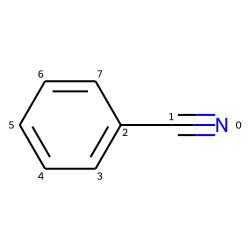

In [106]:
MartiniMoleculeDict = {}
MartiniMoleculeDict['I_MIMI'] = 'Cn1ccnc1'
MartiniMoleculeDict['II_MPYR'] = 'Cc1ccccn1'
MartiniMoleculeDict['II_NIMX'] = 'Cc1c(c(ccc1)C)[N+](=O)[O-]'
MartiniMoleculeDict['II_NITL'] = 'Cc1ccccc1[N+](=O)[O-]'
MartiniMoleculeDict['II_T'] = 'c1cc(sc1)c2cccs2'
MartiniMoleculeDict['III_HT'] = 'CCCCCCc1ccsc1'
MartiniMoleculeDict['III_PT'] = 'CCCc1ccsc1'
MartiniMoleculeDict['IV_MIMI'] = '[nH]1cc(nc1)C'
MartiniMoleculeDict['IV_NIAN'] = 'COc1ccc(cc1)[N+](=O)[O-]'
MartiniMoleculeDict['ACPH'] = 'CC(=O)c1ccccc1'
MartiniMoleculeDict['ANIL'] = 'Nc1ccccc1'
MartiniMoleculeDict['ANTH'] = 'c1ccc2cc3ccccc3cc2c1'
MartiniMoleculeDict['BEAL'] = 'O=Cc1ccccc1'
MartiniMoleculeDict['BENZ'] = 'c1ccccc1'
MartiniMoleculeDict['BRA'] = 'COc1ccc(cc1)Br'
MartiniMoleculeDict['BRBZ'] = 'c1ccc(cc1)Br'
MartiniMoleculeDict['BZDOL'] = 'Oc1cc(ccc1)O'
MartiniMoleculeDict['BZIM'] = 'c1ccc2c(c1)[nH]cn2'
MartiniMoleculeDict['BZNI'] = 'N#Cc1ccccc1'

m  = Chem.MolFromSmiles(MartiniMoleculeDict['BZNI'])
m

In [114]:
MartiniPath_I_MIMI = "/home/sang/Desktop/GIT/Martini3-small-molecules/models/gros/1MIMI.gro"
u = mda.Universe(MartiniPath_I_MIMI) # Create Universe 
for atom in u.atoms:
    print(atom.position, atom.type, atom.residue, atom)

[30.92       6.6000004 24.16     ] N <Residue 1MIMI, 1> <Atom 1: N1 of type N of resname 1MIMI, resid 1 and segid SYSTEM>
[28.82  5.   23.61] N <Residue 1MIMI, 1> <Atom 2: N2 of type N of resname 1MIMI, resid 1 and segid SYSTEM>
[29.86  6.58 21.68] R <Residue 1MIMI, 1> <Atom 3: R3 of type R of resname 1MIMI, resid 1 and segid SYSTEM>


In [62]:
matched_maps,matched_beads = get_smarts_matches(m_aromatic) # Get                                                                                                                                                 


TypeError: 'list' object is not callable

In [103]:
# https://stackoverflow.com/questions/55380743/finding-overlapping-lists-in-a-list-of-lists

substructure1 = Chem.MolFromSmarts('CS') # Aromatic carbons  
substructure2 = Chem.MolFromSmarts('cc') # Aromatic carbons  
Sbeads = m_aromatic.GetSubstructMatches(substructure1)
#ringbeads = m_aromatic.GetSubstructMatches(substructure2)

smarts_strings = {                                                                                                                                                                                     
    'S([O-])(=O)(=O)O':'Qa',                                                                                                                                                                         
    'S([O-])(=O)(=O)[C;!$(*F)]':'Q0',
    'cc':'TC5',
    '[S](=O)(=O)(O[H])C':'Q0',
    'CC(=O)CO':'P2',
    'CS':'SC6', # thiophene
    'cc': 'TC5' # benzene/styrene
    
}  

matched_maps = []                                                                                                                                                                                      
matched_beads = []                                                                                                                                                                                     
for smarts in smarts_strings:  
    #print(smarts)
    matches = m_aromatic.GetSubstructMatches(Chem.MolFromSmarts(smarts))                                                                                                                                      
    for match in matches:                                                                                                                                                                              
        print(match, smarts)
        matched_maps.append(match)                                                                                                                                                               
        matched_beads.append(smarts_strings[smarts])      

matched_beads

(0, 1) cc
(0, 5) cc
(1, 2) cc
(2, 3) cc
(3, 4) cc
(4, 5) cc
(6, 7) CS


['TC5', 'TC5', 'TC5', 'TC5', 'TC5', 'TC5', 'SC6']

In [8]:
get_ring_atoms(m_aromatic)

[[0, 1, 2, 3, 4, 5]]

In [12]:
smiles = "C1=C(C=CC=C1)CS[H]"
mol = Chem.MolFromSmiles(smiles)
AllChem.EmbedMolecule(mol)
ring_atoms = get_ring_atoms(mol)

RDKit WARNING: [14:28:18] Molecule does not have explicit Hs. Consider calling AddHs()


In [13]:
ring_atoms

[[0, 1, 2, 3, 4, 5]]

In [9]:

# TODO 
new_groups = []
# List of possible edge fragments ordered by size, with mappings
edge_frags = collections.OrderedDict()
edge_frags["[R1][R1][R1][R1][R1][R1]"] =  [[0,1],[2,3],[4,5]] # What do these indices mean? 
edge_frags["[R1][R1][R1][R1][R1]"] = [[0,1,2],[2,3]] 
edge_frags["[R1][R1][R1][R1]"] = [[0,1],[2,3]]
edge_frags["[R1][R1][R1]"] =  [[0,1,2]]
edge_frags["[R1][R1]"] = [[0,1]]
edge_frags["[R2][R1][R2]"] = [[0,1,2]]
print(edge_frags)

# Need to go through each stage of this loop

smiles = "C1=C(C=CC=C1)CS[H]"
mol = Chem.MolFromSmiles(smiles)
AllChem.EmbedMolecule(mol)
ring_atoms = get_ring_atoms(mol)




for substruct in edge_frags:
    # From each fragment scaffold match, find the matching indices 
    matches = mol.GetSubstructMatches(Chem.MolFromSmarts(substruct))  # Find the indices of the matching string in the ring
    #print(matches)
    # will show multiple permutations of the matches 
    for match in matches: # Loop over the permutations of all the matched carbon indices
        # match is now a list of indices   
        all_shared = False # Boolean is initially false 
        # Loop over the ring 
        for system in ring_atoms: # Loop over the ring atoms
            #print(system)
            # Check if the matching fragment is within the ring system 
            if all(m in system for m in match):
                all_shared = True 
          
        if not all_shared: # If all_shared is False, continue the code 
            continue # Then we are saying that there is no match for that in the ring 
        # Why is this substruct special? 
        #print(match, substruct)
        if substruct == "[R2][R1][R2]":  # Find if there is an overlap between the ring structure and the fragment 
            overlap = False
            #print("matches:", matches)
            for matchj in matches: # Loop over the list of indices 
                #print(matchj, "matchj, matches", matches)
                if match != matchj: 
                    #print(match, matchj, "match and matchj")
                    if list(set(match).intersection(matchj)):
                        overlap = True
                        break
            if overlap == True:
                continue 
        #print("overlap is ", overlap)
        # Loop over the dict entries
        for bead in edge_frags[substruct]:  # bead prints out the indices of each edge entry 
            #print(bead, match) # [0, 1] (4, 5, 6, 7)
            test_bead = [match[x] for x in bead] # Find the matching 'edge' indices within the match 
            # and stored it inside the test_bead list - e.g/  [0, 1] [2, 3]
            
            #print(bead, test_bead)
            # Not sure what this does.. 
            # If any atoms in n group for n gorup in newgroups is not in 
            # any beads in the test bead, we append the new test_bead 
            """
            For any index entries in new groups array, if any of them 
            is not within the test bead that has been allocated, 
            and append to the new groups the test bead 
            """ 
            if not any(   
                any(y in ngroup for ngroup in new_groups)  # at this point, new_groups is empty 
                for y in test_bead):
                # If we dont have the bead atoms stored, then we store it inside new_groups
                # so new_groups should just have ringed constitutents of the molecule 
                    new_groups.append(test_bead) # Append the new bead index lists to the new_group 
                    
print("new_groups are:", new_groups)
# Get the remaining unmapped atoms                 
unmapped = []
for ring in ring_atoms:
    print("ring atom is ", ring)
    for a in ring:
        # Find the atoms that are not included in new groups and append to the unmapped
        if not any(a in group for group in new_groups): # If not in any of the groups that has been append
                                                        # from the group above 
            unmapped.append(a) # Append to unmapped list  
            #print(unmapped)

"""
Processing the rest of the unmapped fragments 
"""

print("unmapped are", unmapped) # in this case, the unmapped is empty 
if unmapped: # If there are unmapped fragments 
    """
    Go therough the unmapped fragments 
    """
    # Split into continous fragments
    unm_smi = Chem.rdmolfiles.MolFragmentToSmiles(mol,unmapped) # Convert unmapped fragments to smiles 
    print("unm_smi is ", unm_smi)
    # Split into continous fragments
    unm_smi = unm_smi.upper() # Capitalize the unmapped smiles
    unm_mol = Chem.MolFromSmiles(unm_smi) # remake the mol 
    unmapped_frags = Chem.GetMolFrags(unm_mol)  # Finds the disconnected fragments from a molecule 
    print(unmapped_frags)
    
    for frag in unmapped_frags:
        #print(frag)
        indices = [unmapped[k] for k in frag] # Get true indices of the unmapped fragments 
        frag_smi = Chem.rdmolfiles.MolFragmentToSmiles(mol,unmapped) # Convert to smiles 
        frag_smi = frag_smi.upper() # Convert to capital letters 
        frag_mol = Chem.MolFromSmiles(frag_smi)  # Convert to MOL 
        A_frag = np.asarray(Chem.GetAdjacencyMatrix(frag_mol)) # Find the bonded matrix 
        print(A_frag)
        # Check if there are complete rings within unmapped fragments
        frag_ring_atoms = get_ring_atoms(frag_mol) # Find if there are ring atoms within 
        #print(frag_ring_atoms, "dfdf") # Find if any of the unmapped atoms have rings 
        if frag_ring_atoms:
            new_beads = group_rings(A_frag,frag_ring_atoms,matched_maps,frag_mol)[1] # recursively run 
        else:
            new_beads = []
        frag_ring_beads = new_beads[:] 
        print(frag_ring_beads, frag)
        if sum([len(b) for b in frag_ring_beads]) < len(frag):
            # Use floyd warshall algorithm to find the closest distance 
            # between nodes 
            path_frag = floyd_warshall(csgraph = A_frag, directed = False)
            print("That path is ", path_frag)
            w_frag = [1.0 for atom in frag_mol.GetAtoms()]
            print(w_frag, A_frag) # get weights and adjacency of the fragments
            
            # Need to read the paper here..
            
            A_fragw = include_weights(A_frag, w_frag) ### PROBLEM BIT 
            #scores, ties = rank_nodes(A_fragw) 
            comp = [[i] for i in range(frag_mol.GetNumAtoms())]
            new_beads.extend(spectral_grouping)
        
        for bead in new_beads:
            new_groups.append([indices[x] for x in bead])
            
            

OrderedDict([('[R1][R1][R1][R1][R1][R1]', [[0, 1], [2, 3], [4, 5]]), ('[R1][R1][R1][R1][R1]', [[0, 1, 2], [2, 3]]), ('[R1][R1][R1][R1]', [[0, 1], [2, 3]]), ('[R1][R1][R1]', [[0, 1, 2]]), ('[R1][R1]', [[0, 1]]), ('[R2][R1][R2]', [[0, 1, 2]])])
new_groups are: [[0, 1], [2, 3], [4, 5]]
ring atom is  [0, 1, 2, 3, 4, 5]
unmapped are []


RDKit WARNING: [16:15:13] Molecule does not have explicit Hs. Consider calling AddHs()


((0, 3),)


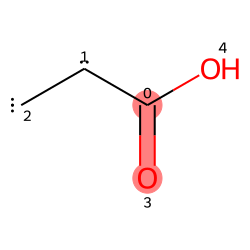

In [131]:
"""
Working with smarts stings
"""
m = Chem.MolFromSmiles('[#6](-[#6]-[#6])(=[#8])-[#8]-[#1]')
substructure = Chem.MolFromSmiles('C=O') # Aromatic carbons 
print(m.GetSubstructMatches(substructure))
m

In [6]:

ms = [Chem.MolFromSmiles('CCOC'), Chem.MolFromSmiles('CCO'),Chem.MolFromSmiles('COC')]
fps = [Chem.RDKFingerprint(x) for x in ms]
fps

# Creating the dictionary to match the similarites of the substructures within the molecule smiles string 

molecule = Chem.MolFromSmiles('CCc1cccc2ccccc21')

SmilesToMartiniDictionary = {}
SmilesToMartiniDictionary["P2"] = "CC(=O)CO"
SmilesToMartiniDictionary["SP2"] = "CC(=O)O"
SmilesToMartiniDictionary["P1"] =  "CC(C)O" 
for entry in SmilesToMartiniDictionary.keys():
    MartiniExtract = Chem.MolFromSmarts(SmilesToMartiniDictionary[entry])
    print(molecule.HasSubstructMatch(MartiniExtract)) 
    

False
False
False


((5, 8),)


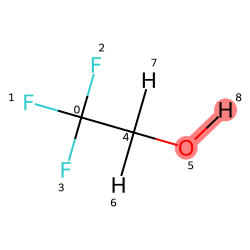

In [67]:
from rdkit.Chem.Draw import IPythonConsole
m = Chem.MolFromSmiles('C(F)(F)(F)CO[H]')
m = Chem.AddHs(m)

AllChem.ComputeGasteigerCharges(m)
u1 = mda.Universe.from_smiles('O[H]')
# Get substructure match 
substructure = Chem.MolFromSmarts('O[H]') # Aromatic carbons  
print(m.GetSubstructMatches(substructure))
m

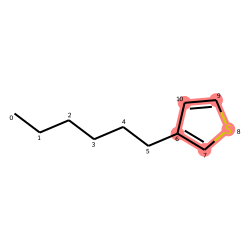

In [155]:
# What is the difference between smart and smiles?

from rdkit.Chem import rdFMCS # rdkit - maximum common substructure
from rdkit.Chem.Draw import rdMolDraw2D
P3HT = 'CCCCCCC1=CSC=C1'
m = Chem.MolFromSmiles(P3HT)
P3HT_thiophene = 'C1=CSC=C1'
#substructure = Chem.MolFromSmarts('[#6]=[#6]-[#6]=[#6]') # Aromatic carbons 
substructure = Chem.MolFromSmiles(P3HT_thiophene) # Aromatic carbons 
mols = [m,substructure] 
res=rdFMCS.FindMCS(mols)
res.smartsString
substructure = Chem.MolFromSmarts(res.smartsString) # Aromatic carbons  
# This gets the indices of the ones that match the substructure 
matches = m.GetSubstructMatch(substructure)
m

In [153]:
from rdkit import Chem

smiles_list = ['C12=CC=CC=C1C3=CC=CC4=C3C2=CC=C4', 'C12=CC=CC=C1C3=CC=C4C5=C(C=CC2=C35)C6=C4C=CC=C6', 'C12=CC=CC=C1C3=CC=C4C5=C(C=CC2=C35)C=C4', 'C12=CC=CC=C1C3=CC=C4C5=C(C=CC2=C35)C6=C4C=C7CCCCC7=C6', 'C12=CC=CC=C1C3=CC=C4C5=C(C=CC2=C35)C6=C4C=C7CC8=CC=CC=C8CC7=C6', 'c1ccccc1']

pattern = Chem.MolFromSmarts('[#6]12~[#6][#6]~[#6][#6]~[#6]1[#6]3~[#6][#6]~[#6][#6]4~[#6]3[#6]2~[#6][#6]~[#6]4')
for idx,smiles in enumerate(smiles_list):
    m = Chem.MolFromSmiles(smiles)
    print("Structure {}: pattern found {}".format(idx+1,m.HasSubstructMatch(pattern)))

Structure 1: pattern found True
Structure 2: pattern found True
Structure 3: pattern found True
Structure 4: pattern found True
Structure 5: pattern found True
Structure 6: pattern found False


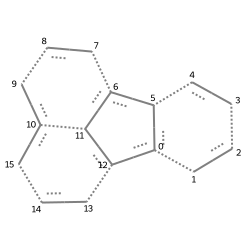

In [154]:
pattern

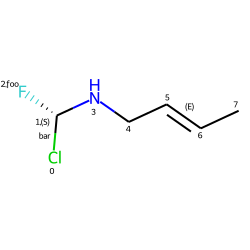

In [133]:
mol = Chem.MolFromSmiles('Cl[C@H](F)NC\C=C\C')
d = rdMolDraw2D.MolDraw2DCairo(250, 200) # or MolDraw2DSVG to get SVGs
mol.GetAtomWithIdx(2).SetProp('atomNote', 'foo')
mol.GetBondWithIdx(0).SetProp('bondNote', 'bar')
mol

In [110]:
res.numAtoms

2

In [74]:
P3HT

'CCCCCCC1=CSC=C1'

((1, 0, 4, 3),)


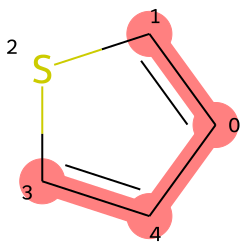

In [16]:
# 
P3HT_thiophene = 'C1=CSC=C1'
m_thiophene = Chem.MolFromSmiles(P3HT_thiophene)
substructure = Chem.MolFromSmarts('cccc') # Aromatic carbons  
print(m_thiophene.GetSubstructMatches(substructure))
m_thiophene

In [8]:
u = mda.Universe.from_smiles("Nc1cc(C[C@H]([O-])C=O)c[nH]1")
u.select_atoms("aromatic").indices
# Get only the sulfuric part 



array([ 1,  2,  3,  9, 10])

In [10]:
for i in u1.atoms:
    print(i.position, i.index + 1, i)

[ 2.830738  -0.6326931  0.3608667] 1 <Atom 1: C0 of type CA resid 1 and segid SYSTEM>
[ 2.0316322  -0.23921199 -0.846957  ] 2 <Atom 2: C1 of type C resid 1 and segid SYSTEM>
[ 0.78656363  0.49960336 -0.5358146 ] 3 <Atom 3: C2 of type C resid 1 and segid SYSTEM>
[ 0.7683207   1.8786193  -0.66736853] 4 <Atom 4: C3 of type C resid 1 and segid SYSTEM>
[-0.37377578  2.6199298  -0.37765527] 5 <Atom 5: C4 of type C resid 1 and segid SYSTEM>
[-1.4972765   1.9277714   0.04927236] 6 <Atom 6: C5 of type C resid 1 and segid SYSTEM>
[-1.5159333   0.55515057  0.19133484] 7 <Atom 7: C6 of type C resid 1 and segid SYSTEM>
[-2.6499987  -0.11618726  0.61893797] 8 <Atom 8: C7 of type C resid 1 and segid SYSTEM>
[-2.6842532  -1.4869646   0.76490164] 9 <Atom 9: C8 of type C resid 1 and segid SYSTEM>
[-1.531114   -2.1829271   0.46668816] 10 <Atom 10: C9 of type C resid 1 and segid SYSTEM>
[-0.39948425 -1.5330176   0.04219323] 11 <Atom 11: C10 of type C resid 1 and segid SYSTEM>
[-0.35161865 -0.14760393 -0.1

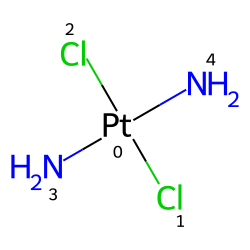

In [60]:
m = Chem.MolFromSmiles('[Pt](Cl)(Cl)(N)N')
m

In [14]:
ListOfTwoAtomFeatures = m.GetSubstructMatches(substructure)

In [26]:
q = rdqueries.IsAromaticQueryAtom()
print([x.GetIdx() for x in m.GetAtomsMatchingQuery(q)]) # These match the indices of the atoms that match the 


[0, 1, 2, 6, 11, 12]


((3, 4, 5), (8, 9, 7))


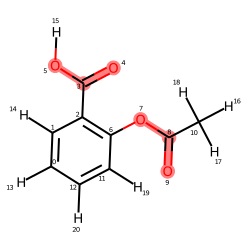

In [18]:
m = Chem.MolFromSmiles('c1cc(C(=O)O)c(OC(=O)C)cc1')
m = Chem.AddHs(m)
substructure = Chem.MolFromSmarts('C(=O)O')
print(m.GetSubstructMatches(substructure))
m

In [28]:
from scipy import ndimage
u2 = mda.Universe.from_smiles('c1cc(C(=O)O)c(OC(=O)C)cc1')
PositionArray = []

for i in u2.atoms:
    if i.index + 1  in [3,4,5]: # Find the index of the atoms which match the smile string 
                                # that match the MARTINI bead 
        PositionArray.append(list(i.position))

PositionArray= np.asarray(PositionArray)
averaged = np.average(PositionArray, axis=0)
averaged # Positions where the new MARTINI bead needs to be placed


#CM = ndimage.measurements.center_of_mass(PositionArray)


array([ 1.0070543, -1.83432  , -0.0984638], dtype=float32)

`auto_martini` has its own function to read in a SMILES string, create a *3-dimensional* conformer, and return an `rdkit` molecule object. We'll use that here:

In [7]:
def get_ring_atoms(mol):                                                                                                                                                                                   
    # get ring atoms and systems of joined rings                                                                                                                                                            
    """
    Get ring atoms and systems of joined rings.
    
    Iterates over the molecule, finds the indices of the ring molecules. 
    
    If there are multiple rings attached together, then it finds the conojoined 
    atoms and does a union which stores the unique indices of atom indices. 
    """

    rings = mol.GetRingInfo().AtomRings() # find atom indices that are part of a ring                                                                                                                                                               
    ring_systems = []                                                                                                                                                                                      
    for ring in rings:                                                                                                                                                                                     
        ring_atoms = set(ring)                                                                                                                                                                             
        new_systems = []                                                                                                                                                                                   
        for system in ring_systems:                                                                                                                                                                        
            shared = len(ring_atoms.intersection(system))                                                                                                                                                  
            if shared:                                                                                                                                                                                     
                ring_atoms = ring_atoms.union(system)                                                                                                                                                      
            else:                                                                                                                                                                                          
                new_systems.append(system)                                                                                                                                                                 
        new_systems.append(ring_atoms)                                                                                                                                                                     
        ring_systems = new_systems                                                                                                                                                                         
                                                                                                                                                                                                           
    return [list(ring) for ring in ring_systems]   

"""
Dissecting the above function 
"""

#smiles = "N=Cc1ccccc1"
smiles = "CNC(=O)c1nccc2cccn12"
mol = Chem.MolFromSmiles(smiles)
#smi = 'cc'
#mol_name = 'MOL'                                                                                                                                                                                                                                                                                                                                                                                                     

#mol = Chem.MolFromSmiles(smi, sanitize=False)           

rings = mol.GetRingInfo().AtomRings() # Finds indices of the atoms that are part of a ring 
print(rings)
ring_systems = [] 
for ring in rings: # Go over each ring 
    ring_atoms = set(ring)
    #print(ring_atoms) # pick out the unique indices that are part of a ring 
    new_systems = [] 
    # TODO 
    for system in ring_systems:
        #print(system)
        shared = len(ring_atoms.intersection(system)) 
        print(shared) # Find shapred atoms between the system and the ring 
        #print(shared)
        if shared:
            ring_atoms = ring_atoms.union(system)
            print(ring_atoms)
        else:
            new_systems.append(system)
    new_systems.append(ring_atoms)
    ring_systems = new_systems

ring_systems # The final total indices of the ring(s) 


#returnVal = [list(ring) for ring in ring_systems]

((4, 12, 8, 7, 6, 5), (9, 8, 12, 11, 10))
2
{4, 5, 6, 7, 8, 9, 10, 11, 12}


[{4, 5, 6, 7, 8, 9, 10, 11, 12}]

In [27]:
matched_maps,matched_beads = get_smarts_matches(mol) # Get                                                                                                                                                                                                                                                                                                                                                   
ring_atoms = get_ring_atoms(mol) # Get the ring indices         # Determining beadtype

def get_types(beads,mol,ring_beads):
    """
    
    """
    #loops through beads and determines bead type                                                                                                                                                          
    path = os.path.dirname(os.path.realpath(__file__))                                                                                                                                                     
    DG_data = read_DG_data('{}/fragment_DGs.dat'.format(path))                                                                                                                                             
    bead_types = []                                                                                                                                                                                        
    charges = []                                                                                                                                                                                           
    all_smi = []                                                                                                                                                                                           
    h_donor,h_acceptor = get_hbonding(mol,beads)                                                                                                                                                           
    for i,bead in enumerate(beads):                                                                                                                                                                        
        qbead = sum([mol.GetAtomWithIdx(int(j)).GetFormalCharge() for j in bead])                                                                                                                          
        charges.append(qbead)                                                                                                                                                                              
        bead_smi,ring_size, frag_size = get_smi(bead,mol)                                                                                                                                                  
        all_smi.append(bead_smi)                                                                                                                                                                           
        bead_types.append(param_bead(bead,bead_smi,ring_size,frag_size,any(i in ring for ring in ring_beads),qbead,i in h_donor,i in h_acceptor,DG_data))                                                  
                                                                                                                                                                                                           
    return(bead_types,charges,all_smi)        

In [28]:
ring_atoms

[[4, 5, 6, 7, 8, 9, 10, 11, 12]]

In [57]:
matched_maps,matched_beads = get_smarts_matches(mol) # Get                                                                                                                                                                                                                                                                                                                                                           
ring_atoms = get_ring_atoms(mol) # Get the ring indices         
A_atom = np.asarray(Chem.GetAdjacencyMatrix(mol)) # Get connection matrix, or the adjecency matrix                                                                                                                                                      
path_matrix = floyd_warshall(csgraph=A_atom,directed=False) # find the score for the shortest distance                                                                                                                                            
w_init = [atom.GetMass() for atom in mol.GetAtoms()] # Get mass of each atom and store in array     
ring_beads,comp,A_init = group_rings(A_atom,ring_atoms,matched_maps,mol)

TypeError: cannot unpack non-iterable NoneType object

In [52]:
def include_weights(A,w):                                                                                                                                                                                  
    # Weights atoms by setting diagonal components                                                                                                                                                         
    A_weighted = np.copy(A)                                                                                                                                                                                
    for i,weight in enumerate(w):                                                                                                                                                                          
        A_weighted[i,i] = weight                                                                                                                                                                           
                                                                                                                                                                                                           
    return A_weighted 


def rank_nodes(A):                                                                                                                                                                                         
    # Ranks nodes by absolute eigenvector components of largest eigenvalue                                                                                                                                 
    vals,vecs = np.linalg.eig(A)                                                                                                                                                                           
    maxval = np.argmax(vals)                                                                                                                                                                               
    scores = np.absolute(vecs[:,maxval])                                                                                                                                                                   
    scores = scores/np.amin(scores)                                                                                                                                                                        
    ranked = np.argsort(scores)                                                                                                                                                                            
                                                                                                                                                                                                           
    ties = []                                                                                                                                                                                              
    sublist = []                                                                                                                                                                                           
                                                                                                                                                                                                           
    # Create ranked list with tied nodes at the same rank                                                                                                                                                  
    score_prev = scores[ranked[0]]                                                                                                                                                                         
    for i in ranked:                                                                                                                                                                                       
        score_i = scores[i]                                                                                                                                                                                
        if np.isclose(score_i,score_prev):                                                                                                                                                                 
            sublist.append(i)                                                                                                                                                                              
        else:                                                                                                                                                                                              
            ties.append(sublist)                                                                                                                                                                           
            sublist = [i]                                                                                                                                                                                  
        score_prev = score_i                                                                                                                                                                               
    ties.append(sublist)    

In [70]:
## Checking the include_weights function 
w = [1.0, 1.0]
A = np.array([[0,1], [0, 1]])
              
#def include_weights(A,w):                                                                                                                                                                                  
#    # Weights atoms by setting diagonal components                                                                                                                                                         
#    A_weighted = np.copy(A)                                                                                                                                                                                
#    for i,weight in enumerate(w):                                                                                                                                                                          
#        A_weighted[i,i] = weight                                                                                                                                                                           
#                                                                                                                                                                                                          
#    return A_weighted 
A_weighted = np.copy(A)
A_weighted

for i, weight in enumerate(w):
    #print(i, weight)
    A_weighted[i,i] = weight 

A_weighted

## Checking the rank_nodes

def rank_nodes(A):                                                                                                                                                                                         
    """
    
    """
    # Ranks nodes by absolute eigenvector components of largest eigenvalue                                                                                                                                 
    vals,vecs = np.linalg.eig(A)                                                                                                                                                                           
    maxval = np.argmax(vals)                                                                                                                                                                               
    scores = np.absolute(vecs[:,maxval])                                                                                                                                                                   
    scores = scores/np.amin(scores)                                                                                                                                                                        
    ranked = np.argsort(scores)                                                                                                                                                                            
                                                                                                                                                                                                           
    ties = []                                                                                                                                                                                              
    sublist = []                                                                                                                                                                                           
                                                                                                                                                                                                           
    # Create ranked list with tied nodes at the same rank                                                                                                                                                  
    score_prev = scores[ranked[0]]                                                                                                                                                                         
    for i in ranked:                                                                                                                                                                                       
        score_i = scores[i]                                                                                                                                                                                
        if np.isclose(score_i,score_prev):                                                                                                                                                                 
            sublist.append(i)                                                                                                                                                                              
        else:                                                                                                                                                                                              
            ties.append(sublist)                                                                                                                                                                           
            sublist = [i]                                                                                                                                                                                  
        score_prev = score_i                                                                                                                                                                               
    ties.append(sublist)    

array([[1, 1],
       [0, 1]])

In [34]:
ring_beads

[[0, 1], [2, 3], [8, 9], [10, 11], [4, 13, 12], [5, 6, 7]]

In [121]:
import copy
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
 
mol1 = Chem.MolFromSmiles("C1CCNCC1")
mol2 = Chem.MolFromSmiles("c1ccccc1")
mol3 = Chem.MolFromSmiles("C1CC1CC")
mol4 = Chem.MolFromSmiles("C1CC1CCC2CCOC2")
mol5 = Chem.MolFromSmiles("C1CCC2CCCCC2C1")
mol6 = Chem.MolFromSmiles("OC1CC2(C1)CCCC2")
mol7 = Chem.MolFromSmiles("CC1CCN(CC1N(C)C2=NC=NC3=C2C=CN3)C(=O)CC#N")
mol8 = Chem.MolFromSmiles("c1ccccc1c2ccccc2OC")
mol9 = Chem.MolFromSmiles("CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C)NC4=NC=CC(=N4)C5=CN=CC=C5")
mol10 = Chem.MolFromSmiles("C1CCCC1CCCOCOCOCOCOCc1ccccc1")
mols = [mol1,mol2,mol3,mol4,mol5,mol6,mol7,mol8,mol9,mol10]

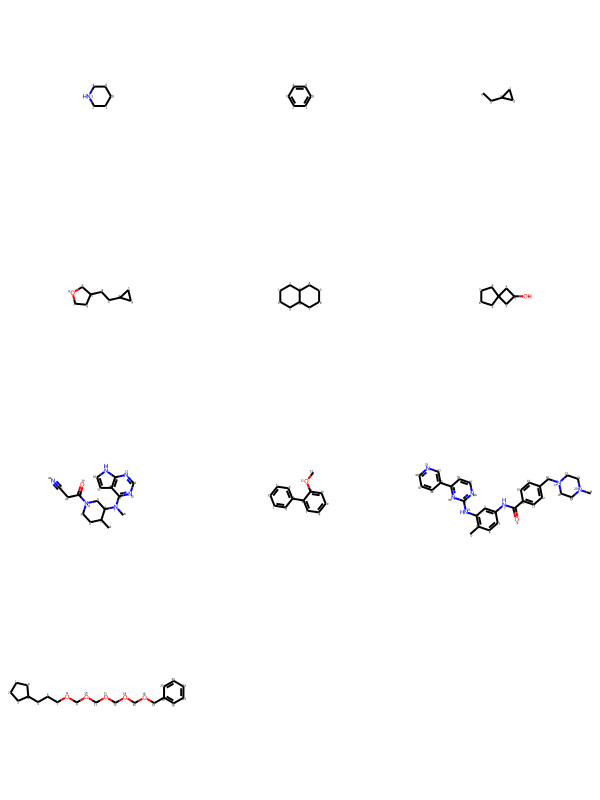

In [122]:
Draw.MolsToGridImage(mols, molsPerRow=3)

RDKit WARNING: [14:47:03] Molecule does not have explicit Hs. Consider calling AddHs()


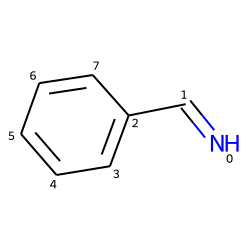

In [35]:
smiles = "N=Cc1ccccc1"
mol = Chem.MolFromSmiles(smiles)
Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
mol